In [1]:
import os
import pandas as pd
import numpy as np
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean, std
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Combine all PDBs into a single dataframe
dfs = []
for filename in os.listdir('data/features_ring'):
    if filename[-4:] == '.tsv':
        dfs.append(pd.read_csv('data/features_ring/' + filename, sep='\t'))
df = pd.concat(dfs)

df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,2i49,A,72,,A,H,0.009,27.0,25.0,-0.757,...,23.0,-1.164,-0.788,H,-1.239,-0.547,2.131,0.393,0.816,HBOND
1,2i49,A,372,,F,H,0.000,22.0,21.0,-1.024,...,16.0,-1.135,-0.767,H,-0.228,1.399,-4.760,0.670,-2.647,HBOND
2,2i49,A,212,,D,-,0.117,8.0,21.0,-1.411,...,11.0,-1.578,-0.295,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND
3,2i49,A,212,,D,-,0.117,8.0,21.0,-1.411,...,11.0,-1.578,-0.295,H,1.050,0.302,-3.656,-0.259,-3.242,VDW
4,2i49,A,145,,A,E,0.000,26.0,25.0,-2.866,...,24.0,-1.059,-0.730,H,-0.228,1.399,-4.760,0.670,-2.647,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,4fuu,A,164,,V,H,0.000,25.0,11.0,-1.068,...,19.0,-1.281,2.247,H,0.931,-0.179,-3.005,-0.503,-1.853,VDW
467,4fuu,A,106,,N,E,0.019,24.0,21.0,-1.482,...,24.0,-1.601,2.917,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND
468,4fuu,A,147,,A,I,0.000,20.0,31.0,-1.134,...,9.0,-1.361,1.309,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND
469,4fuu,A,198,,W,S,0.242,12.0,24.0,-1.512,...,23.0,-1.043,-0.784,H,0.931,-0.179,-3.005,-0.503,-1.853,NaN


We download training PDB files and merge them into a single dataframe.
The raw data has 735510 rows and 34 columns.

## Data preprocessing and exploration

In [3]:
# Remove all rows with NaN in the Interaction column
df = df[df['Interaction'].notna()]

# Define ground truth values
y = df['Interaction'].astype('category')
y

0      HBOND
1      HBOND
2      HBOND
3        VDW
5      HBOND
       ...  
464    HBOND
465      VDW
466      VDW
467    HBOND
468    HBOND
Name: Interaction, Length: 510098, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

The data is presented by 12 categorical and 22 numeric variables.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510098 entries, 0 to 468
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pdb_id       510098 non-null  object 
 1   s_ch         510098 non-null  object 
 2   s_resi       510098 non-null  int64  
 3   s_ins        510098 non-null  object 
 4   s_resn       510098 non-null  object 
 5   s_ss8        462585 non-null  object 
 6   s_rsa        462585 non-null  float64
 7   s_up         509199 non-null  float64
 8   s_down       509199 non-null  float64
 9   s_phi        507246 non-null  float64
 10  s_psi        508950 non-null  float64
 11  s_ss3        506118 non-null  object 
 12  s_a1         510098 non-null  float64
 13  s_a2         510098 non-null  float64
 14  s_a3         510098 non-null  float64
 15  s_a4         510098 non-null  float64
 16  s_a5         510098 non-null  float64
 17  t_ch         510098 non-null  object 
 18  t_resi       510098 non-nul

In [5]:
#fill na values with most frequent values
for i in df.columns:
    df[i]=df[i].fillna(df[i].value_counts().idxmax())
df

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].fillna(df[i].value_counts().idxmax())
/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].fillna(df[i].value_counts().idxmax())
/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].fillna(df[i].value_counts().idxmax())
/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].fillna(df[i].value_counts().idxmax())
/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4750/3427928469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,2i49,A,72,,A,H,0.009,27.0,25.0,-0.757,...,23.0,-1.164,-0.788,H,-1.239,-0.547,2.131,0.393,0.816,HBOND
1,2i49,A,372,,F,H,0.000,22.0,21.0,-1.024,...,16.0,-1.135,-0.767,H,-0.228,1.399,-4.760,0.670,-2.647,HBOND
2,2i49,A,212,,D,-,0.117,8.0,21.0,-1.411,...,11.0,-1.578,-0.295,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND
3,2i49,A,212,,D,-,0.117,8.0,21.0,-1.411,...,11.0,-1.578,-0.295,H,1.050,0.302,-3.656,-0.259,-3.242,VDW
5,2i49,A,178,,G,T,0.119,5.0,14.0,-1.796,...,8.0,-1.175,-0.760,H,1.831,-0.561,0.533,-0.277,1.648,HBOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,4fuu,A,246,,N,H,0.000,21.0,18.0,-1.035,...,18.0,-1.191,-0.754,H,-1.337,-0.279,-0.544,1.242,-1.262,HBOND
465,4fuu,A,237,,Y,H,0.180,18.0,14.0,-1.115,...,11.0,-2.279,2.190,H,-1.239,-0.547,2.131,0.393,0.816,VDW
466,4fuu,A,164,,V,H,0.000,25.0,11.0,-1.068,...,19.0,-1.281,2.247,H,0.931,-0.179,-3.005,-0.503,-1.853,VDW
467,4fuu,A,106,,N,E,0.019,24.0,21.0,-1.482,...,24.0,-1.601,2.917,H,1.050,0.302,-3.656,-0.259,-3.242,HBOND


Since NaN class represents a different type of bond not related to others, we remove it from our dataset.

In [6]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

# Calculate percentiles and tranform into categories
X = X.rank(pct=True).round(1).astype('category') 
X

,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_rsa,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5
0,0.3,1.0,0.9,1.0,0.0,0.4,0.1,0.4,1.0,0.5,0.1,0.8,0.9,0.6,0.1,0.1,0.4,0.8,0.5,0.6
1,0.1,0.8,0.7,0.9,0.3,0.3,0.3,0.8,0.2,0.6,0.1,0.9,0.5,0.6,0.2,0.5,0.9,0.0,0.6,0.1
2,0.6,0.2,0.7,0.4,0.7,0.8,0.7,0.1,0.3,0.0,0.7,0.4,0.2,0.3,0.5,0.8,0.7,0.1,0.4,0.0
3,0.6,0.2,0.7,0.4,0.7,0.8,0.7,0.1,0.3,0.0,0.7,0.4,0.2,0.3,0.5,0.8,0.7,0.1,0.4,0.0
5,0.6,0.1,0.3,0.2,0.6,0.4,0.9,0.6,0.7,0.9,1.0,0.1,0.1,0.5,0.2,1.0,0.4,0.5,0.3,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,0.1,0.8,0.6,0.8,0.2,0.7,0.8,0.6,0.4,0.7,0.3,1.0,0.6,0.5,0.2,0.0,0.5,0.4,0.8,0.2
465,0.6,0.6,0.3,0.6,0.5,0.6,0.8,1.0,0.1,0.8,0.6,0.6,0.2,0.1,0.7,0.1,0.4,0.8,0.5,0.6
466,0.1,0.9,0.1,0.8,0.3,0.0,0.5,0.4,0.8,0.2,0.8,0.3,0.7,0.4,0.8,0.7,0.6,0.1,0.2,0.1
467,0.4,0.9,0.7,0.3,0.8,0.7,0.8,0.6,0.4,0.7,0.1,0.9,0.9,0.3,1.0,0.8,0.7,0.1,0.4,0.0


After preprocessing we are left with 510098 rows and 20 columns.

## Statistics on the data

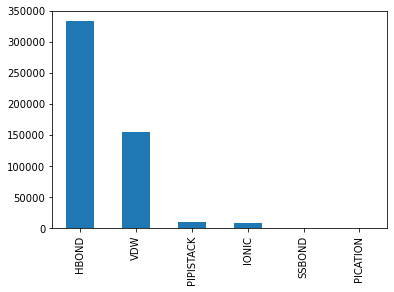

In [7]:
df.Interaction.value_counts().plot.bar()
plt.show()

There are some types of bonds that are easy to identify even without the algorithms. For example, SSBOND has the same Atcheley features:

In [38]:
SSBOND_ATCH = df[df['Interaction'] == 'SSBOND'][['s_a1', 's_a2', 's_a3', 's_a4', 's_a5',
    't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]
SSBOND_ATCH.describe()

,s_a1,s_a2,s_a3,s_a4,s_a5,t_a1,t_a2,t_a3,t_a4,t_a5
count,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02,8.660000e+02
mean,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01
std,5.109977e-15,7.276163e-15,3.999113e-15,1.155299e-14,2.888248e-15,5.109977e-15,7.276163e-15,3.999113e-15,1.155299e-14,2.888248e-15
min,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01
25%,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01
50%,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01
75%,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01
max,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01,-1.343000e+00,4.650000e-01,-8.620000e-01,-1.020000e+00,-2.550000e-01


Moreover, it's clearly noticeable that some types of bonds have less options for residues in s_resn column.

In [55]:
df_bonds = df.loc[:,['Interaction', 's_resn']]
#df_bonds = df.loc[:,['s_resn', 'Interaction']]
df_bonds.value_counts()

Interaction  s_resn
HBOND        L         33311
             A         30642
             D         24205
             E         23211
             V         23024
             S         20133
             I         19007
             G         18447
             T         18142
             R         17034
             K         16962
             N         15721
VDW          L         14647
HBOND        Q         14107
             F         13409
VDW          Y         13369
HBOND        Y         13344
VDW          F         13237
             N         10809
             V         10260
             I          9523
HBOND        P          9310
VDW          Q          8221
             R          8058
HBOND        H          7162
VDW          D          7094
             W          7047
             A          6994
             E          6470
HBOND        M          6256
VDW          T          6232
             H          5990
HBOND        W          5833
VDW          K         

In [11]:
#Check if there are NaN values
for i in X.columns:
    if 'NaN' in X[i]:
        print('there are NaN values')

## Check performance of the models

We proceed with the evaluation of the original dataset and one with applied oversampling. Both datasets are divided in training and testing parts. Then three algorithms are performed on each array.

The original data has the next dimension:

In [12]:
print(X.shape)

(510098, 20)


We implemented 4 algorithms: Naive Bayes (Gaussian), Logistic Regression, Random Forest and Neural Network.

The accuracies of the models on imbalanced dataset is in 61-72%. The highest f-1 score is obtained by HBOND, the lowest - by PICATION, which is only 0. Taking into account the imbalancing of the data it's evident that all models have a good prediction of the most frequent class. However, it's not a right option in our case: we can easily predict ourselves such kind of interactions as SSBOND, PICATION, PIPISTACK and IONIC. Clearly the models can perform better.

How the models performance would be changed with the balancing of the data?
For this we implemented the undersampling technique. 

In [15]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()), X_resampled.shape)

[('HBOND', 626), ('IONIC', 626), ('PICATION', 626), ('PIPISTACK', 626), ('SSBOND', 626), ('VDW', 626)] (3756, 20)


Now we obtained the same number of instances for all the classes, and check if our assumption of the best model performance is right. We repeat the same steps as we did with imbalanced data, with the same 4 algorithms.

Here we show the results of the algorithm which performed the best - Random Forest Classifier.

In [16]:
# Split the dataset to define training and testing examples - oversampled
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 0)

In [17]:
# Random Forest
rf = RandomForestClassifier()
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d; accuracy :" 
      % (X_test.shape[0], (y_test != y_pred_rf).sum()), accuracy_score(y_test, y_pred_rf, normalize=True))

Number of mislabeled points out of a total 376 points : 66; accuracy : 0.824468085106383


In [18]:
print(classification_report(y_test, y_pred_rf, zero_division=1))

              precision    recall  f1-score   support

       HBOND       0.65      0.55      0.59        73
       IONIC       0.91      0.98      0.95        54
    PICATION       0.92      1.00      0.96        65
   PIPISTACK       0.91      0.98      0.94        52
      SSBOND       1.00      1.00      1.00        66
         VDW       0.56      0.53      0.54        66

    accuracy                           0.82       376
   macro avg       0.82      0.84      0.83       376
weighted avg       0.81      0.82      0.82       376



In [19]:
#save to the disk the trained model
import joblib
name_of_the_model = './random_forest.pkl'
joblib.dump(rf, name_of_the_model)

['./random_forest.pkl']